In [99]:
import torch
import requests
from pathlib import Path
from zipfile import ZipFile
import zipfile
import os

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

if image_path.is_dir():
  print(f"{image_path} already exists...")
else:
  image_path.mkdir(parents=True, exist_ok=True)

file_path = data_path / "pizza_steak_sushi_20_percent.zip"
if not file_path.exists():
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip")
  file_path = data_path / "pizza_steak_sushi_20_percent.zip"
  print(f"Downloading {file_path}")
  with open(file_path, "wb") as f:
    f.write(request.content)
  with zipfile.ZipFile(file_path, "r") as zip_ref:
    zip_ref.extractall(image_path)
  print(f"Download and unzipping successful. Deleting zip file...")
  os.remove(file_path)
else:
  print(f"Zip file has already been downloaded. Skipping download...")

data/pizza_steak_sushi_20_percent already exists...
Download and unzipping successful. Deleting zip file...


In [100]:
from torchvision import datasets, transforms

train_data_path = image_path / "train"
test_data_path = image_path / "test"

transform = transforms.Compose([
                                transforms.Resize((100, 100)),
                                transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_data_path, transform=transform)
test_data = datasets.ImageFolder(test_data_path, transform=transform)

class_names = train_data.classes

In [101]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [102]:
!pip install torchinfo

In [103]:
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary
import torch.nn as nn

weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last two layers (layer4 and fc)
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

summary(model=model,
        input_size=(32, 3, 100, 100),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 100, 100]    [32, 1000]           --                   Partial
├─Conv2d (conv1)                         [32, 3, 100, 100]    [32, 64, 50, 50]     (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 50, 50]     [32, 64, 50, 50]     (128)                False
├─ReLU (relu)                            [32, 64, 50, 50]     [32, 64, 50, 50]     --                   --
├─MaxPool2d (maxpool)                    [32, 64, 50, 50]     [32, 64, 25, 25]     --                   --
├─Sequential (layer1)                    [32, 64, 25, 25]     [32, 256, 25, 25]    --                   False
│    └─Bottleneck (0)                    [32, 64, 25, 25]     [32, 256, 25, 25]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 25, 25]     [32, 64, 25, 25]     (4,096)              False
│    │    

In [104]:
loss_fn = torch.nn.CrossEntropyLoss()
# Optimize parameters of layer4 and fc
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 0.0003},
    {'params': model.fc.parameters(), 'lr': 0.0003}
], lr=0.0003)

In [105]:
from tqdm.auto import tqdm

NUM_EPOCHS = 7

results = {
           "train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
}

for epoch in tqdm(range(NUM_EPOCHS)):
  print(f"Epoch: {epoch}\n----------")

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    y_logits = model(X)
    y_class = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    train_acc += (y_class == y).sum().item()/len(y_class)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  for batch, (X, y) in enumerate(test_dataloader):
    model.eval()
    with torch.inference_mode():
      test_logits = model(X)
      test_class = torch.softmax(test_logits, dim=1).argmax(dim=1)

      loss = loss_fn(test_logits, y)
      test_loss += loss.item()
      test_acc += (test_class == y).sum().item()/len(test_class)

  test_loss /= len(test_dataloader)
  test_acc /= len(test_dataloader)

  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_acc)

  print(f"Train loss: {train_loss:.3f}, Train acc {train_acc:.3f}% | Test loss: {test_loss:.3f}, Test acc: {test_acc:.3f}%\n")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 6.262, Train acc 0.042% | Test loss: 4.742, Test acc: 0.220%

Epoch: 1
----------
Train loss: 2.622, Train acc 0.529% | Test loss: 1.343, Test acc: 0.667%

Epoch: 2
----------
Train loss: 0.728, Train acc 0.771% | Test loss: 0.500, Test acc: 0.820%

Epoch: 3
----------
Train loss: 0.381, Train acc 0.898% | Test loss: 0.391, Test acc: 0.832%

Epoch: 4
----------
Train loss: 0.236, Train acc 0.935% | Test loss: 0.312, Test acc: 0.882%

Epoch: 5
----------
Train loss: 0.181, Train acc 0.942% | Test loss: 0.323, Test acc: 0.879%

Epoch: 6
----------
Train loss: 0.113, Train acc 0.963% | Test loss: 0.271, Test acc: 0.891%



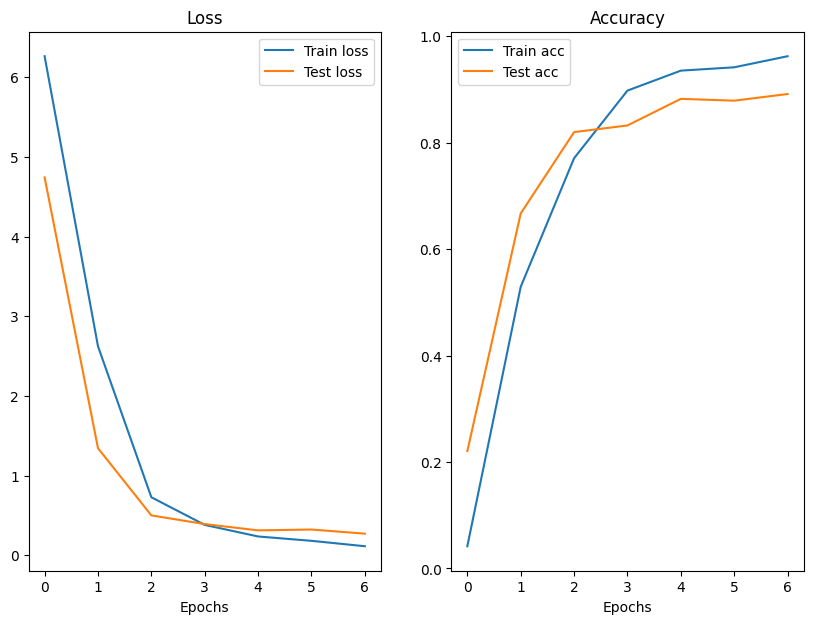

In [106]:
from matplotlib import pyplot as plt

train_loss = results["train_loss"]
train_acc = results["train_acc"]

test_loss = results["test_loss"]
test_acc = results["test_acc"]

epochs = range(len(train_loss))

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Test loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train acc")
plt.plot(test_acc, label="Test acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

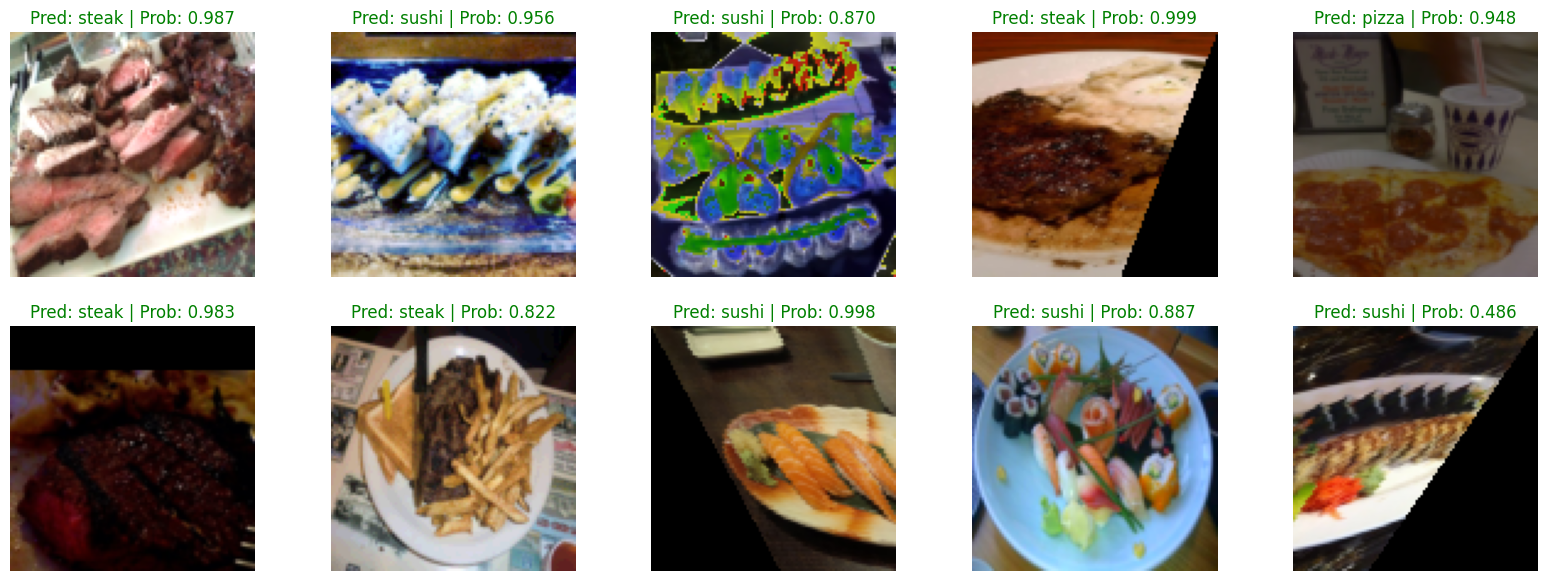

In [112]:
from matplotlib import pyplot as plt
import random
from PIL import Image

plt.figure(figsize=(20, 7))
for i in range(0, 10):
  random_img_path, random_img_class = random.choice(test_data.imgs)
  random_img = Image.open(random_img_path)
  random_img = transform(random_img)

  model.eval()
  with torch.inference_mode():
    y_logits = model(random_img.unsqueeze(dim=0))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_class_idx = torch.argmax(y_pred_probs, dim=1)

    plt.subplot(2, 5, i+1)
    plt.imshow(random_img.permute(1, 2, 0))
    color = "green" if (y_class_idx==random_img_class) else "red"
    plt.title (f"Pred: {class_names[y_class_idx]} | Prob: {y_pred_probs.max():.3f}", color=color)
    plt.axis(False)